# TEXT CLASSIFICATION WITH BLAZING TEXT

## SECTION 1: Configuration and Setup

This is the only section students "SHOULD" need to modify.  
It defines all key parameters needed to run the notebook pipeline from start to finish.  
Once these are set, the rest of the workflow will execute automatically.

This section:

- Specifies the dataset file and its location  
- Identifies which columns contain the text and the label  
- Supports custom label remapping if needed  
- Allows manual or automatic class count detection  
- Sets a minimum sample size per class to avoid training issues  
- Enables common preprocessing options like stopword removal and emoji stripping  
- Lets students choose whether to automatically delete the model endpoint after testing  
- Defines SageMaker settings like endpoint name, instance types, and S3 prefix  

By configuring these values, students customize the pipeline for their dataset while keeping everything else automated.


In [1]:
# ------------------------------------------------------------------------------
# DATASET SETTINGS
# ------------------------------------------------------------------------------

# Name of the CSV file you uploaded to the SageMaker Jupyter environment.
# It should be in the same directory as this notebook.
DATASET_FILE = "Restaurant_Reviews_BINARY.csv"  # Example: "customer_reviews.csv"

# List of columns that contain the text input.
# If you have more than one text column, list them in order. They will be concatenated.
TEXT_COLUMNS = ["cleaned_text_str"]  # Example: ["title", "body"], or ["feedback"]

# The name of the column that contains the labels you want to predict.
# Labels can be binary (e.g., Positive/Negative), multi-class, or numeric ratings.
LABEL_COLUMN = "Rating"  # Example: "Sentiment", "Label", "Category"

# Optional dictionary to remap label values.
# Use this if your dataset has custom labels like {"Like": "5"} or {"pos": "Positive"}.
LABEL_MAP = {
    "Like": "5"  # Modify as needed. Leave empty if no remapping is required.
}

# If known, you can set the number of unique classes (labels) in advance.
# Otherwise, leave this as None and it will be determined automatically.
NUM_CLASSES = None  # Example: 2, 3, or None

# Minimum number of samples required per class.
# Classes with fewer samples will be removed to avoid training errors.
MIN_SAMPLES_PER_CLASS = 10  # Example: 10, 20, 50

# ------------------------------------------------------------------------------
# TEXT PREPROCESSING OPTIONS
# ------------------------------------------------------------------------------

# Whether to remove common stopwords like "the", "is", "and", etc.
APPLY_STOPWORDS = True

# Whether to remove emojis, emoticons, and other non-standard symbols.
REMOVE_EMOJIS = True

# Whether to apply basic spelling correction (experimental, may slow down processing).
SPELL_CHECK = False

# ------------------------------------------------------------------------------
# CLEANUP CONFIGURATION
# ------------------------------------------------------------------------------

# If set to True, the SageMaker endpoint will be automatically deleted after testing.
# If set to False, the user will be prompted to decide.
CLEANUP = False

# ------------------------------------------------------------------------------
# SAGEMAKER AND INFRASTRUCTURE SETTINGS
# ------------------------------------------------------------------------------

# Name for the deployed endpoint. This must be unique within your AWS account.
ENDPOINT_NAME = "blazingtext-classification"  # Example: "textclassifier-john-doe"

# Instance type used for training the model.
INSTANCE_TYPE = "ml.m5.large"

# Instance type used to deploy the model for real-time inference.
DEPLOY_INSTANCE_TYPE = "ml.m5.large"

# Prefix for files stored in your S3 bucket (used internally by SageMaker).
PREFIX = "blazingtext-sentiment"


## SECTION 2: Environment Setup and Imports

This section:

- Imports all required Python libraries  
- Sets up the SageMaker session and AWS role  
- Ensures necessary NLTK resources are downloaded  
- Handles execution from within SageMaker notebooks (assumed environment)  
- Initializes SageMaker and AWS resources  
- Sets up logging for consistent outputs  
- Prepares environment to run NLTK tokenization and lemmatization  
- Supports both managed (SageMaker Notebook) and unmanaged (local) execution contexts


In [2]:
# Standard library imports
import os
import re
import time
import json
import logging
import string

# Third-party imports
import boto3
from botocore.exceptions import ClientError
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Natural Language Processing (NLTK)
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# SageMaker SDK
import sagemaker
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.estimator import Estimator

# Download required NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# SageMaker session and role
session = sagemaker.Session()
region = boto3.Session().region_name
bucket = session.default_bucket()

# Attempt to get execution role (works inside SageMaker Notebook)
try:
    role = sagemaker.get_execution_role()
    logger.info("Using SageMaker execution role.")
except Exception:
    # Fallback: attempt to get role via STS
    sts = boto3.client("sts")
    role = sts.get_caller_identity()["Arn"]
    logger.warning("Falling back to STS for role ARN.")

logger.info(f"Using role: {role}")
logger.info(f"Using bucket: {bucket}")
logger.info(f"Region: {region}")


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[04/02/25 10:29:30] INFO     Found credentials from IAM Role:                                   ]8;id=633239;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=913834;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[04/02/25 10:29:31] INFO     Found credentials from IAM Role:                                   ]8;id=216820;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=272428;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[04/02/25 10:29:32] INFO     Found credentials from IAM Role:                                   ]8;id=254963;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=567455;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Using SageMaker execution role.                                       ]8;id=473917;file:///tmp/ipykernel_11276/1760151327.py\1760151327.py]8;;\:]8;id=916405;file:///tmp/ipykernel_11276/1760151327.py#58\58]8;;\

                    INFO     Using role: arn:aws:iam::042610003076:role/LabRole                    ]8;id=122697;file:///tmp/ipykernel_11276/1760151327.py\1760151327.py]8;;\:]8;id=878476;file:///tmp/ipykernel_11276/1760151327.py#65\65]8;;\

                    INFO     Using bucket: sagemaker-us-east-1-042610003076                        ]8;id=195677;file:///tmp/ipykernel_11276/1760151327.py\1760151327.py]8;;\:]8;id=513956;file:///tmp/ipykernel_11276/1760151327.py#66\66]8;;\

                    INFO     Region: us-east-1                                                     ]8;id=374737;file:///tmp/ipykernel_11276/1760151327.py\1760151327.py]8;;\:]8;id=853373;file:///tmp/ipykernel_11276/1760151327.py#67\67]8;;\

## SECTION 3: Dataset Loading and Validation

This section will:

- Attempt to load the dataset file specified in `DATASET_FILE`  
- Raise an error if the file is not found in the current working directory  
- Display the first few rows of the dataset for inspection  
- List all available columns to help confirm input structure  
- Verify that the specified text and label columns exist in the dataset  
- Raise an error if any required columns are missing  
- Combine multiple text columns (if more than one is provided) into a single `combined_text` column  
- Apply custom label remapping if a `LABEL_MAP` is defined  
- Drop any rows with missing text or labels, and log how many were removed  
- Convert labels to string type for consistency  
- Show the distribution of label values before class filtering is applied

After this section, the notebook will have:

- Validated all required input columns  
- Created a single column for processed text input  
- Cleaned and filtered out incomplete records  
- Applied any necessary label transformations  
- Logged the label distribution to prepare for class filtering


In [3]:
# Load the dataset
try:
    df = pd.read_csv(DATASET_FILE)
    logger.info(f"Successfully loaded dataset: {DATASET_FILE}")
except FileNotFoundError:
    raise FileNotFoundError(f"Dataset file '{DATASET_FILE}' not found in current directory.")

# Preview dataset
logger.info("Dataset Preview:")
display(df.head())

# List available columns
logger.info("Available columns in dataset:")
print(df.columns.tolist())

# Check if specified columns exist
missing_columns = [col for col in TEXT_COLUMNS + [LABEL_COLUMN] if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following columns were not found in the dataset: {missing_columns}")

# Combine multiple text columns (if needed)
df["combined_text"] = df[TEXT_COLUMNS].astype(str).agg(" ".join, axis=1)

# Apply label mapping if specified
if LABEL_MAP:
    df[LABEL_COLUMN] = df[LABEL_COLUMN].replace(LABEL_MAP)

# Drop rows with missing values in key columns
initial_size = len(df)
df.dropna(subset=["combined_text", LABEL_COLUMN], inplace=True)
after_drop = len(df)
logger.info(f"Dropped {initial_size - after_drop} rows with missing text or labels.")

# Optionally convert labels to string type
df[LABEL_COLUMN] = df[LABEL_COLUMN].astype(str)

# Show class distribution before filtering
logger.info("Label distribution (before filtering):")
print(df[LABEL_COLUMN].value_counts())


                    INFO     Successfully loaded dataset: Restaurant_Reviews_BINARY.csv             ]8;id=42845;file:///tmp/ipykernel_11276/2350880736.py\2350880736.py]8;;\:]8;id=776466;file:///tmp/ipykernel_11276/2350880736.py#4\4]8;;\

                    INFO     Dataset Preview:                                                       ]8;id=199046;file:///tmp/ipykernel_11276/2350880736.py\2350880736.py]8;;\:]8;id=323382;file:///tmp/ipykernel_11276/2350880736.py#9\9]8;;\

,Rating,cleaned_text_str
0,1,ambience good food quite good saturday lunch c...
1,1,ambience good pleasant evening service prompt ...
2,1,must try great food great ambience thnx servic...
3,1,soumen da arun great guy behavior sincerety go...
4,1,food goodwe ordered kodi drumstick basket mutt...


                    INFO     Available columns in dataset:                                         ]8;id=561534;file:///tmp/ipykernel_11276/2350880736.py\2350880736.py]8;;\:]8;id=905484;file:///tmp/ipykernel_11276/2350880736.py#13\13]8;;\

['Rating', 'cleaned_text_str']


                    INFO     Dropped 0 rows with missing text or labels.                           ]8;id=560457;file:///tmp/ipykernel_11276/2350880736.py\2350880736.py]8;;\:]8;id=860188;file:///tmp/ipykernel_11276/2350880736.py#32\32]8;;\

                    INFO     Label distribution (before filtering):                                ]8;id=613775;file:///tmp/ipykernel_11276/2350880736.py\2350880736.py]8;;\:]8;id=901113;file:///tmp/ipykernel_11276/2350880736.py#38\38]8;;\

1    5949
0    3493
Name: Rating, dtype: int64


## SECTION 4: Class Filtering and Label Analysis

This section will:

- Count the number of samples per class in the dataset  
- Filter out label classes with fewer than `MIN_SAMPLES_PER_CLASS` examples  
- Log which classes were retained and how many samples each contains  
- Automatically determine the number of classes if `NUM_CLASSES` was not set manually  
- Display a bar chart showing class distribution after filtering  
- Normalize label values by stripping whitespace and replacing spaces with underscores to ensure compatibility with BlazingText formatting

After this section, the notebook will have:

- Removed underrepresented classes to ensure reliable training  
- Inferred the number of classes from the data if not explicitly set  
- Visualized the balanced class distribution for validation  
- Cleaned label names in preparation for BlazingText input format


                    INFO     Classes retained (with at least 10 samples):                            ]8;id=352179;file:///tmp/ipykernel_11276/442612220.py\442612220.py]8;;\:]8;id=814691;file:///tmp/ipykernel_11276/442612220.py#7\7]8;;\

1    5949
0    3493
Name: Rating, dtype: int64


                    INFO     Number of classes inferred from data: 2                                ]8;id=754002;file:///tmp/ipykernel_11276/442612220.py\442612220.py]8;;\:]8;id=507482;file:///tmp/ipykernel_11276/442612220.py#13\13]8;;\

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=845220;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=255020;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=135753;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=715591;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

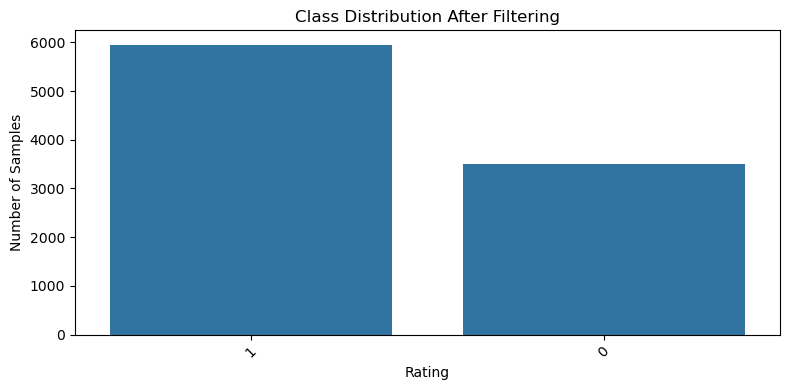

In [4]:
# Filter out classes with too few samples
class_counts = df[LABEL_COLUMN].value_counts()
valid_classes = class_counts[class_counts >= MIN_SAMPLES_PER_CLASS].index.tolist()

df = df[df[LABEL_COLUMN].isin(valid_classes)]

logger.info(f"Classes retained (with at least {MIN_SAMPLES_PER_CLASS} samples):")
print(df[LABEL_COLUMN].value_counts())

# Automatically detect number of classes if not provided
if NUM_CLASSES is None:
    NUM_CLASSES = df[LABEL_COLUMN].nunique()
    logger.info(f"Number of classes inferred from data: {NUM_CLASSES}")
else:
    logger.info(f"Number of classes defined by user: {NUM_CLASSES}")

# Plot class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=LABEL_COLUMN, data=df, order=df[LABEL_COLUMN].value_counts().index)
plt.title("Class Distribution After Filtering")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Normalize label names for BlazingText (__label__ formatting requires clean text)
df[LABEL_COLUMN] = df[LABEL_COLUMN].str.strip().str.replace(" ", "_")


## SECTION 5: Text Preprocessing

This section will:

- Check that all required configuration variables are loaded from Section 1  
- Initialize tools for tokenization, lemmatization, and optional spell correction  
- Define a regex pattern to remove emojis and symbols (if enabled)  
- Clean and normalize text by:  
  - Lowercasing  
  - Removing URLs and HTML tags  
  - Stripping emojis and non-standard symbols (optional)  
  - Removing stopwords (optional)  
  - Applying lemmatization  
  - Correcting spelling (optional and basic)  
- Apply the cleaning function to the combined text column and store results in a new `cleaned_text` column  
- Compute token counts for each cleaned entry and generate summary statistics  
- Remove extreme outliers based on token length (5th to 95th percentile range)  
- Show a sample of cleaned text with corresponding labels for review

After this section, the notebook will have:

- A cleaned and normalized version of the text data  
- Fewer outliers that could distort model learning  
- Basic quality checks through token statistics  
- Previewed examples to help students verify preprocessing settings


In [5]:
# Safety check: Make sure config variables are loaded
required_vars = ["SPELL_CHECK", "REMOVE_EMOJIS", "APPLY_STOPWORDS", "TEXT_COLUMNS", "LABEL_COLUMN"]
for var in required_vars:
    if var not in globals():
        raise RuntimeError(f"Configuration variable '{var}' is not defined. Please run Section 1 first.")

# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r"\w+")
stop_words = set(stopwords.words("english")) if APPLY_STOPWORDS else set()

# Optional: Emoji and symbol removal pattern
emoji_pattern = re.compile("[" 
    u"\U0001F600-\U0001F64F"  # Emoticons
    u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # Transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
    "]+", flags=re.UNICODE
)

# Optional: Basic spell correction using TextBlob
if SPELL_CHECK:
    try:
        from textblob import TextBlob
    except ImportError:
        raise ImportError("TextBlob is not installed. Please run: !pip install textblob")

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)

    if REMOVE_EMOJIS:
        text = emoji_pattern.sub(r"", text)

    tokens = tokenizer.tokenize(text)

    if SPELL_CHECK:
        tokens = [str(TextBlob(token).correct()) for token in tokens]

    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
logger.info("Cleaning and preprocessing text...")
df["cleaned_text"] = df["combined_text"].astype(str).apply(clean_text)

# Token count statistics
df["num_tokens"] = df["cleaned_text"].apply(lambda x: len(x.split()))
logger.info("Token statistics after cleaning:")
print(df["num_tokens"].describe())

# Remove outliers based on token count
low_th, high_th = np.percentile(df["num_tokens"], [5, 95])
df = df[(df["num_tokens"] >= low_th) & (df["num_tokens"] <= high_th)]
logger.info(f"Filtered out reviews with token count outside range {low_th:.1f} to {high_th:.1f}")

# Preview cleaned samples
logger.info("Sample cleaned text:")
display(df[["cleaned_text", LABEL_COLUMN]].sample(5))


                    INFO     Cleaning and preprocessing text...                                    ]8;id=746610;file:///tmp/ipykernel_11276/2330955664.py\2330955664.py]8;;\:]8;id=21558;file:///tmp/ipykernel_11276/2330955664.py#45\45]8;;\

[04/02/25 10:29:38] INFO     Token statistics after cleaning:                                      ]8;id=897211;file:///tmp/ipykernel_11276/2330955664.py\2330955664.py]8;;\:]8;id=629674;file:///tmp/ipykernel_11276/2330955664.py#50\50]8;;\

count    9442.000000
mean       21.712773
std        15.895262
min         1.000000
25%        13.000000
50%        19.000000
75%        28.000000
max        79.000000
Name: num_tokens, dtype: float64


                    INFO     Filtered out reviews with token count outside range 1.0 to 55.0       ]8;id=146676;file:///tmp/ipykernel_11276/2330955664.py\2330955664.py]8;;\:]8;id=302421;file:///tmp/ipykernel_11276/2330955664.py#56\56]8;;\

                    INFO     Sample cleaned text:                                                  ]8;id=982981;file:///tmp/ipykernel_11276/2330955664.py\2330955664.py]8;;\:]8;id=482415;file:///tmp/ipykernel_11276/2330955664.py#59\59]8;;\

,cleaned_text,Rating
4500,shanghai chef quite time twice kobe sizzlers m...,1
713,great one bad one either try packaging isnt gr...,0
4408,got know place tv show went try biriyani order...,1
1552,ordered lucknowi veg galouti kebab paratha zom...,0
256,great fun kid family exceptional hospitality e...,1


## SECTION 6: Exploratory Visualizations

This section will:

- Plot the distribution of label classes after preprocessing using a bar chart  
- Plot a histogram of token counts to show the distribution of text lengths  
- Print example cleaned texts for each label class to help visually validate preprocessing quality

These visualizations provide a helpful checkpoint before training, allowing students to confirm that:

- The dataset remains balanced after cleaning and filtering  
- The token length distribution is reasonable  
- The cleaned text still preserves meaningful language features

After this section, the notebook will have:

- A visual summary of class distribution  
- A histogram showing how long the text samples are (in tokens)  
- A few sample cleaned reviews per label to verify text quality


                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=366628;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=250475;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=192409;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=838737;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

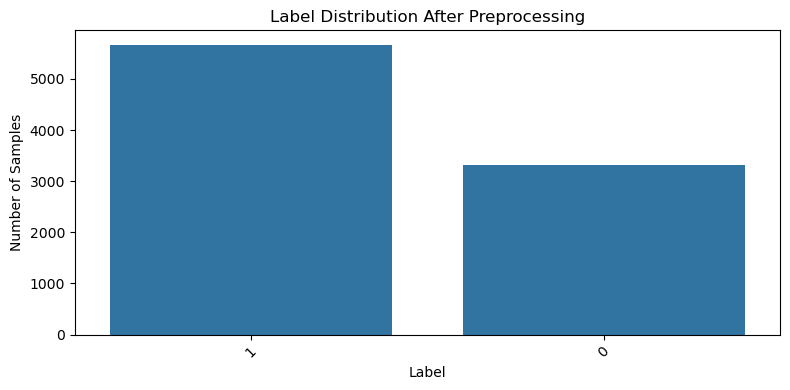

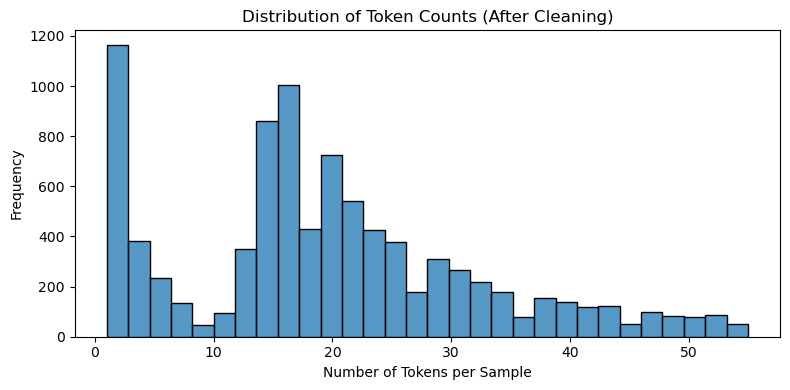

[04/02/25 10:29:39] INFO     Sample cleaned texts per label:                                       ]8;id=524009;file:///tmp/ipykernel_11276/3077917005.py\3077917005.py]8;;\:]8;id=264767;file:///tmp/ipykernel_11276/3077917005.py#21\21]8;;\


Label: 1
Example 1: simply love taste everything order place
Example 2: try many thing chicken dum biryani good quantity good single person much two people enough would need get shake something like hungry full till neckthat like eating biryani two person normal eater winwin

Label: 0
Example 1: worst ever experience booking place corporate dinner courtesy sense talk customer reservation team intention business would never ever recommend place anyone
Example 2: k baker known food bakery item ordered veg hot dog premium butter scotch pastry italian chocolate pastry veg hot dog stuffed aloo onion tomato slice mayonnaise taste good pastry also worth try overall ok


In [6]:
# Plot label distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x=LABEL_COLUMN, order=df[LABEL_COLUMN].value_counts().index)
plt.title("Label Distribution After Preprocessing")
plt.xlabel("Label")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot distribution of token counts
plt.figure(figsize=(8, 4))
sns.histplot(df["num_tokens"], bins=30, kde=False)
plt.title("Distribution of Token Counts (After Cleaning)")
plt.xlabel("Number of Tokens per Sample")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Show example cleaned texts for each label
logger.info("Sample cleaned texts per label:")
for label in df[LABEL_COLUMN].unique():
    print(f"\nLabel: {label}")
    sample_texts = df[df[LABEL_COLUMN] == label]["cleaned_text"].sample(2, random_state=42)
    for i, txt in enumerate(sample_texts, 1):
        print(f"Example {i}: {txt}")


## SECTION 7: LDA File Generation

This section will:

- Create a local output folder (`lda_texts`) to store LDA input files  
- Loop through each unique label in the dataset  
- Save all cleaned text samples for each label into separate `.txt` files  
- Ensure each file contains one cleaned review per line  
- Prepare the text files for downstream topic modeling using tools like Gensim or SageMaker LDA

After this section, the notebook will have:

- One plain text file per label class  
- Each file containing cleaned reviews formatted for topic modeling  
- A structured folder ready for input to LDA or similar unsupervised analysis tools


In [7]:
logger.info("Generating text files for LDA topic modeling...")

# Create a folder to store LDA files
lda_output_folder = "lda_texts"
os.makedirs(lda_output_folder, exist_ok=True)

# Save one file per label
label_list = df[LABEL_COLUMN].unique()
for label in label_list:
    file_path = os.path.join(lda_output_folder, f"{label}_texts.txt")
    subset = df[df[LABEL_COLUMN] == label]["cleaned_text"]
    with open(file_path, "w", encoding="utf-8") as f:
        for line in subset:
            f.write(line.strip().replace("\n", " ") + "\n")
    logger.info(f"Saved: {file_path}")


                    INFO     Generating text files for LDA topic modeling...                        ]8;id=94041;file:///tmp/ipykernel_11276/3125096628.py\3125096628.py]8;;\:]8;id=564488;file:///tmp/ipykernel_11276/3125096628.py#1\1]8;;\

                    INFO     Saved: lda_texts/1_texts.txt                                          ]8;id=66415;file:///tmp/ipykernel_11276/3125096628.py\3125096628.py]8;;\:]8;id=888817;file:///tmp/ipykernel_11276/3125096628.py#15\15]8;;\

                    INFO     Saved: lda_texts/0_texts.txt                                          ]8;id=35279;file:///tmp/ipykernel_11276/3125096628.py\3125096628.py]8;;\:]8;id=285732;file:///tmp/ipykernel_11276/3125096628.py#15\15]8;;\

## SECTION 8: Train / Validation / Test Split

This section will:

- Split the cleaned and filtered dataset into three subsets:  
  - 70% for training  
  - 15% for validation  
  - 15% for testing  
- Use stratified sampling to preserve the original class distribution across all splits  
- Log the number of samples in each subset  
- Optionally display the label distribution in each split to confirm balance

Stratified splitting is used to help ensure that all label classes are fairly represented across the training, validation, and test sets.

After this section, the notebook will have:

- Separate datasets for training, validation, and final evaluation  
- Class distributions that mirror the original dataset  
- Logged counts for each split to support reproducibility and transparency


In [8]:
# First split: train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df[LABEL_COLUMN],
    random_state=42
)

# Second split: validation (15%) and test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df[LABEL_COLUMN],
    random_state=42
)

# Report sizes
logger.info("Data split completed.")
logger.info(f"Training set size: {len(train_df)}")
logger.info(f"Validation set size: {len(val_df)}")
logger.info(f"Test set size: {len(test_df)}")

# Optional: display class distribution in each split
def show_split_distribution(name, subset):
    print(f"\n{name} class distribution:")
    print(subset[LABEL_COLUMN].value_counts())

show_split_distribution("Training", train_df)
show_split_distribution("Validation", val_df)
show_split_distribution("Test", test_df)


                    INFO     Data split completed.                                                 ]8;id=851368;file:///tmp/ipykernel_11276/3418380189.py\3418380189.py]8;;\:]8;id=479519;file:///tmp/ipykernel_11276/3418380189.py#18\18]8;;\

                    INFO     Training set size: 6287                                               ]8;id=218015;file:///tmp/ipykernel_11276/3418380189.py\3418380189.py]8;;\:]8;id=40701;file:///tmp/ipykernel_11276/3418380189.py#19\19]8;;\

                    INFO     Validation set size: 1347                                             ]8;id=455705;file:///tmp/ipykernel_11276/3418380189.py\3418380189.py]8;;\:]8;id=944719;file:///tmp/ipykernel_11276/3418380189.py#20\20]8;;\

                    INFO     Test set size: 1348                                                   ]8;id=136413;file:///tmp/ipykernel_11276/3418380189.py\3418380189.py]8;;\:]8;id=696520;file:///tmp/ipykernel_11276/3418380189.py#21\21]8;;\


Training class distribution:
1    3966
0    2321
Name: Rating, dtype: int64

Validation class distribution:
1    850
0    497
Name: Rating, dtype: int64

Test class distribution:
1    850
0    498
Name: Rating, dtype: int64


## SECTION 9: Preparing BlazingText Format

This section will:

- Format the training, validation, and test datasets to match BlazingText’s required input format  
- Convert each row into a line with the structure: `__label__<label> cleaned text`  
- Normalize labels by lowercasing and replacing spaces with underscores  
- Strip and clean input text to ensure it meets formatting expectations  
- Write three output files: `train.txt`, `validation.txt`, and `test.txt`, each containing one sample per line

This formatting is necessary for BlazingText’s supervised mode, which expects labeled text in a specific structure.

After this section, the notebook will have:

- Three `.txt` files, one for each dataset split  
- Cleaned and labeled text entries ready for S3 upload and SageMaker training


In [9]:
def create_blazingtext_file(df_subset, filename):
    with open(filename, "w", encoding="utf-8") as f:
        for _, row in df_subset.iterrows():
            label = str(row[LABEL_COLUMN]).lower().strip().replace(" ", "_")
            text = str(row["cleaned_text"]).strip().replace("\n", " ")
            if label and text:
                f.write(f"__label__{label} {text}\n")

# Create formatted files
create_blazingtext_file(train_df, "train.txt")
create_blazingtext_file(val_df, "validation.txt")
create_blazingtext_file(test_df, "test.txt")

logger.info("Formatted text files created for BlazingText:")
logger.info(" - train.txt")
logger.info(" - validation.txt")
logger.info(" - test.txt")


                    INFO     Formatted text files created for BlazingText:                          ]8;id=883371;file:///tmp/ipykernel_11276/144093799.py\144093799.py]8;;\:]8;id=518721;file:///tmp/ipykernel_11276/144093799.py#14\14]8;;\

                    INFO      - train.txt                                                           ]8;id=819697;file:///tmp/ipykernel_11276/144093799.py\144093799.py]8;;\:]8;id=864773;file:///tmp/ipykernel_11276/144093799.py#15\15]8;;\

                    INFO      - validation.txt                                                      ]8;id=539483;file:///tmp/ipykernel_11276/144093799.py\144093799.py]8;;\:]8;id=679981;file:///tmp/ipykernel_11276/144093799.py#16\16]8;;\

                    INFO      - test.txt                                                            ]8;id=232041;file:///tmp/ipykernel_11276/144093799.py\144093799.py]8;;\:]8;id=281749;file:///tmp/ipykernel_11276/144093799.py#17\17]8;;\

## SECTION 10: Uploading Files to Amazon S3

This section will:

- Define S3 key paths for each dataset split using the configured `PREFIX`  
- Upload `train.txt`, `validation.txt`, and `test.txt` to the specified S3 bucket  
- Store each file in a structured subfolder (`train/`, `validation/`, `test/`)  
- Log the full S3 URIs so students can see where their data is stored

These files are required for the SageMaker training job and must be accessible in S3.

After this section, the notebook will have:

- Successfully uploaded training, validation, and test data to Amazon S3  
- S3 paths that are structured and ready to be used as input for BlazingText training  
- Logged URIs that confirm the upload was successful and traceable


In [10]:
# Define S3 key prefix path (subfolder)
train_key = f"{PREFIX}/train/train.txt"
val_key = f"{PREFIX}/validation/validation.txt"
test_key = f"{PREFIX}/test/test.txt"

# Upload to S3
train_s3_uri = session.upload_data(path="train.txt", bucket=bucket, key_prefix=f"{PREFIX}/train")
val_s3_uri = session.upload_data(path="validation.txt", bucket=bucket, key_prefix=f"{PREFIX}/validation")
test_s3_uri = session.upload_data(path="test.txt", bucket=bucket, key_prefix=f"{PREFIX}/test")

logger.info("Data uploaded to S3:")
logger.info(f" - Training data:    {train_s3_uri}")
logger.info(f" - Validation data: {val_s3_uri}")
logger.info(f" - Test data:       {test_s3_uri}")


[04/02/25 10:29:40] INFO     Data uploaded to S3:                                                   ]8;id=285231;file:///tmp/ipykernel_11276/507553151.py\507553151.py]8;;\:]8;id=392168;file:///tmp/ipykernel_11276/507553151.py#11\11]8;;\

                    INFO      - Training data:                                                      ]8;id=189649;file:///tmp/ipykernel_11276/507553151.py\507553151.py]8;;\:]8;id=827926;file:///tmp/ipykernel_11276/507553151.py#12\12]8;;\
                             s3://sagemaker-us-east-1-042610003076/blazingtext-sentiment/train/trai                
                             n.txt                                                                                 

                    INFO      - Validation data:                                                    ]8;id=601157;file:///tmp/ipykernel_11276/507553151.py\507553151.py]8;;\:]8;id=232478;file:///tmp/ipykernel_11276/507553151.py#13\13]8;;\
                             s3://sagemaker-us-east-1-042610003076/blazingtext-sentiment/validation                
                             /validation.txt                                                                       

                    INFO      - Test data:                                                          ]8;id=14577;file:///tmp/ipykernel_11276/507553151.py\507553151.py]8;;\:]8;id=13598;file:///tmp/ipykernel_11276/507553151.py#14\14]8;;\
                             s3://sagemaker-us-east-1-042610003076/blazingtext-sentiment/test/test.                
                             txt                                                                                   

## SECTION 11: Training the BlazingText Model

This section will:

- Retrieve the correct container image URI for the BlazingText algorithm in the current AWS region  
- Initialize a SageMaker Estimator configured for the selected training instance type  
- Set BlazingText hyperparameters such as mode, number of epochs, learning rate, and minimum word count  
- Define the training and validation input channels using the uploaded S3 URIs  
- Launch a fully managed training job on SageMaker using the provided settings

The model will be trained in **supervised mode**, meaning it will learn to predict labels based on the training data provided.

After this section, the notebook will have:

- Started a SageMaker training job using the cleaned and preprocessed dataset  
- Configured BlazingText with appropriate hyperparameters for classification  
- Logged the training progress, either in the notebook or in the SageMaker console


In [11]:
bt_image_uri = image_uris.retrieve("blazingtext", region=region)

# Initialize the SageMaker Estimator
bt_estimator = Estimator(
    image_uri=bt_image_uri,
    role=role,
    instance_count=1,
    instance_type=INSTANCE_TYPE,
    output_path=f"s3://{bucket}/{PREFIX}/output",
    sagemaker_session=session
)

# Set BlazingText hyperparameters
bt_estimator.set_hyperparameters(
    mode="supervised",
    epochs=10,
    learning_rate=0.05,
    word_ngrams=1,
    min_count=2
)

# Launch the training job
logger.info("Starting training job with BlazingText on SageMaker...")

bt_estimator.fit({
    "train": TrainingInput(train_s3_uri, distribution="FullyReplicated"),
    "validation": TrainingInput(val_s3_uri, distribution="FullyReplicated")
})


                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=947781;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=647988;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=535997;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=346718;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Found credentials from IAM Role:                                   ]8;id=318429;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=165370;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Starting training job with BlazingText on SageMaker...                ]8;id=805070;file:///tmp/ipykernel_11276/3556772473.py\3556772473.py]8;;\:]8;id=440757;file:///tmp/ipykernel_11276/3556772473.py#23\23]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=842577;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=695952;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name: blazingtext-2025-04-02-10-29-40-586   ]8;id=289897;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=712510;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

2025-04-02 10:29:40 Starting - Starting the training job...
2025-04-02 10:30:09 Starting - Preparing the instances for training...
2025-04-02 10:30:33 Downloading - Downloading input data......
2025-04-02 10:31:33 Training - Training image download completed. Training in progress.Arguments: train
[04/02/2025 10:31:37 WARNING 140255874778944] Loggers have already been setup.
[04/02/2025 10:31:37 WARNING 140255874778944] Loggers have already been setup.
/opt/amazon/python3.8/lib/python3.8/subprocess.py:848: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
[04/02/2025 10:31:37 INFO 140255874778944] nvidia-smi took: 0.025224685668945312 secs to identify 0 gpus
[04/02/2025 10:31:37 INFO 140255874778944] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[04/02/2025 10:31:37 INFO 140255874778944] Processing /opt/ml/

## SECTION 12: Model Deployment

This section will:

- Check whether an existing SageMaker endpoint with the same name already exists  
- If found, safely delete the existing endpoint and its configuration  
- Wait for the endpoint to be fully deleted before proceeding (with status updates logged)  
- Deploy the newly trained BlazingText model to a real-time inference endpoint  
- Configure the deployed model to accept and return data in JSON format using `JSONSerializer` and `JSONDeserializer`

This ensures that students can safely re-run the notebook without manual cleanup and have a fresh deployment each time.

After this section, the notebook will have:

- Removed any previously deployed endpoint with the same name  
- Deployed the current model version to a new SageMaker endpoint  
- A configured predictor object that can be used for real-time text classification


In [12]:
sm_client = boto3.client("sagemaker")

def delete_existing_endpoint(endpoint_name):
    try:
        sm_client.describe_endpoint(EndpointName=endpoint_name)
        logger.info(f"Existing endpoint found: {endpoint_name}. Deleting...")
        sm_client.delete_endpoint(EndpointName=endpoint_name)
    except ClientError:
        logger.info(f"No existing endpoint named {endpoint_name} to delete.")

    try:
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
        logger.info(f"Deleted existing endpoint config: {endpoint_name}")
    except ClientError:
        logger.info(f"No existing endpoint config to delete for: {endpoint_name}")

    # Wait for endpoint deletion
    logger.info("Waiting for endpoint deletion to complete...")
    while True:
        try:
            status = sm_client.describe_endpoint(EndpointName=endpoint_name)
            logger.info(f"Endpoint status: {status['EndpointStatus']} — still deleting...")
            time.sleep(5)
        except ClientError as e:
            if "Could not find endpoint" in str(e):
                logger.info("Endpoint deletion confirmed.")
                break
            else:
                raise e

# Perform cleanup and redeploy
delete_existing_endpoint(ENDPOINT_NAME)

logger.info(f"Deploying model to endpoint: {ENDPOINT_NAME}")
predictor = bt_estimator.deploy(
    initial_instance_count=1,
    instance_type=DEPLOY_INSTANCE_TYPE,
    endpoint_name=ENDPOINT_NAME
)

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

logger.info("Model successfully deployed and ready for inference.")


[04/02/25 10:32:28] INFO     Existing endpoint found: blazingtext-classification. Deleting...        ]8;id=890450;file:///tmp/ipykernel_11276/976856035.py\976856035.py]8;;\:]8;id=936848;file:///tmp/ipykernel_11276/976856035.py#6\6]8;;\

                    INFO     Deleted existing endpoint config: blazingtext-classification           ]8;id=54872;file:///tmp/ipykernel_11276/976856035.py\976856035.py]8;;\:]8;id=644024;file:///tmp/ipykernel_11276/976856035.py#13\13]8;;\

                    INFO     Waiting for endpoint deletion to complete...                           ]8;id=26182;file:///tmp/ipykernel_11276/976856035.py\976856035.py]8;;\:]8;id=108186;file:///tmp/ipykernel_11276/976856035.py#18\18]8;;\

                    INFO     Endpoint status: Deleting — still deleting...                          ]8;id=465943;file:///tmp/ipykernel_11276/976856035.py\976856035.py]8;;\:]8;id=732967;file:///tmp/ipykernel_11276/976856035.py#22\22]8;;\

[04/02/25 10:32:33] INFO     Endpoint deletion confirmed.                                           ]8;id=537841;file:///tmp/ipykernel_11276/976856035.py\976856035.py]8;;\:]8;id=934822;file:///tmp/ipykernel_11276/976856035.py#26\26]8;;\

                    INFO     Deploying model to endpoint: blazingtext-classification                ]8;id=304606;file:///tmp/ipykernel_11276/976856035.py\976856035.py]8;;\:]8;id=940103;file:///tmp/ipykernel_11276/976856035.py#34\34]8;;\

                    INFO     Creating model with name: blazingtext-2025-04-02-10-32-33-519          ]8;id=856059;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=466890;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/02/25 10:32:34] INFO     Creating endpoint-config with name blazingtext-classification          ]8;id=650500;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=817779;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name blazingtext-classification                 ]8;id=757360;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=965048;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

-----!

[04/02/25 10:35:35] INFO     Model successfully deployed and ready for inference.                   ]8;id=323122;file:///tmp/ipykernel_11276/976856035.py\976856035.py]8;;\:]8;id=636546;file:///tmp/ipykernel_11276/976856035.py#44\44]8;;\

## SECTION 13: Batch Prediction on the Test Set

This section will:

- Define a function to send cleaned test inputs to the deployed endpoint in manageable batches  
- Send requests to the SageMaker endpoint using the predictor object  
- Extract and clean the top predicted label from the response, removing the `__label__` prefix  
- Attach the predictions to the test DataFrame in a new column called `predicted_label`  
- Display a sample of actual vs. predicted labels for manual inspection

Batching the input helps avoid overwhelming the endpoint with too many requests at once and ensures efficient inference.

After this section, the notebook will have:

- Generated predictions for all test samples  
- Attached predicted labels to the corresponding entries in the test DataFrame  
- Displayed a preview of the model’s performance on unseen examples


In [13]:
def batch_predict(predictor, texts, batch_size=100):
    """
    Sends text data in batches to the deployed endpoint and returns predicted labels.
    """
    predictions = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]

        # Make prediction request
        response = predictor.predict({
            "instances": batch,
            "configuration": {"k": 1}
        })

        for result in response:
            labels = result.get("label", [])
            probs = result.get("prob", [])

            if labels and probs:
                # Extract label and remove __label__ prefix
                predicted = labels[0].replace("__label__", "").capitalize()
                predictions.append(predicted)
            else:
                predictions.append("Unknown")

    return predictions

logger.info("Running batch predictions on test set...")
test_df["predicted_label"] = batch_predict(predictor, test_df["cleaned_text"].tolist())

logger.info("Sample predictions (actual vs. predicted):")
display(test_df[[LABEL_COLUMN, "predicted_label", "cleaned_text"]].sample(5, random_state=1))


                    INFO     Running batch predictions on test set...                              ]8;id=484878;file:///tmp/ipykernel_11276/2090662569.py\2090662569.py]8;;\:]8;id=558593;file:///tmp/ipykernel_11276/2090662569.py#29\29]8;;\

                    INFO     Sample predictions (actual vs. predicted):                            ]8;id=549259;file:///tmp/ipykernel_11276/2090662569.py\2090662569.py]8;;\:]8;id=328756;file:///tmp/ipykernel_11276/2090662569.py#32\32]8;;\

,Rating,predicted_label,cleaned_text
6935,1,1,unique concept cafe hiring bike car enjoying c...
6673,1,1,staff friendly polite one best chinese restaur...
7094,1,1,good boy
1837,1,1,delivered time
156,1,1,awesome food service degraded compared last ye...


## SECTION 14: Model Evaluation and Metric Explanation

This section will:

- Compute a confusion matrix to compare true vs. predicted labels  
- Display the confusion matrix as a heatmap for easy interpretation  
- Calculate key evaluation metrics:  
  - Accuracy  
  - Precision (weighted)  
  - Recall (weighted)  
  - F1 Score (weighted)  
- Print a detailed classification report for deeper insight into per-class performance  
- Use `zero_division=0` to safely handle edge cases where a class has no predicted samples

These metrics help evaluate how well the model is performing, both overall and for individual classes.

After this section, the notebook will have:

- A visual summary of prediction accuracy using a confusion matrix  
- Weighted classification metrics to handle class imbalance  
- A full classification report showing per-class performance for transparency and diagnostics


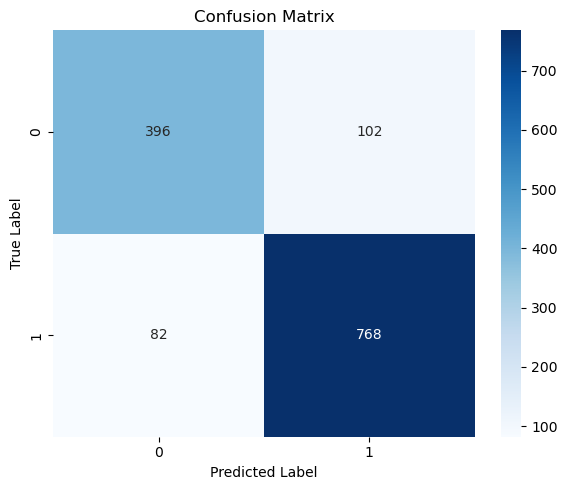

Evaluation Metrics:
 - Accuracy : 0.8635
 - Precision: 0.8627
 - Recall   : 0.8635
 - F1 Score : 0.8629

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       498
           1       0.88      0.90      0.89       850

    accuracy                           0.86      1348
   macro avg       0.86      0.85      0.85      1348
weighted avg       0.86      0.86      0.86      1348



In [14]:
# Confusion matrix
labels = sorted(df[LABEL_COLUMN].unique())
cm = confusion_matrix(test_df[LABEL_COLUMN], test_df["predicted_label"], labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

accuracy = accuracy_score(test_df[LABEL_COLUMN], test_df["predicted_label"])
precision = precision_score(test_df[LABEL_COLUMN], test_df["predicted_label"], average="weighted", zero_division=0)
recall = recall_score(test_df[LABEL_COLUMN], test_df["predicted_label"], average="weighted", zero_division=0)
f1 = f1_score(test_df[LABEL_COLUMN], test_df["predicted_label"], average="weighted", zero_division=0)

print("Evaluation Metrics:")
print(f" - Accuracy : {accuracy:.4f}")
print(f" - Precision: {precision:.4f}")
print(f" - Recall   : {recall:.4f}")
print(f" - F1 Score : {f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(test_df[LABEL_COLUMN], test_df["predicted_label"], zero_division=0))


## SECTION 15: Interactive Inference and Optional Cleanup

This section will:

- Allow students to input custom review text and receive real-time predictions from the deployed endpoint  
- Display the top predicted label along with the model’s confidence score  
- Run in a loop until the user types `'exit'` to end the session  
- Prompt the user to delete the SageMaker endpoint when done (or delete it automatically if `CLEANUP = True`)  
- Help students avoid unnecessary AWS charges by managing the endpoint lifecycle

This is the final step where students can directly interact with the trained model and optionally shut down their resources.

After this section, the notebook will have:

- Enabled live model testing through the command line  
- Returned predictions for student-generated input  
- Handled safe and optional endpoint cleanup based on configuration or user input


In [ ]:
def predict_custom_input(text_input):
    """
    Sends a single review to the deployed endpoint and returns the predicted label.
    """
    response = predictor.predict({
        "instances": [text_input],
        "configuration": {"k": 1}
    })

    if response and "label" in response[0]:
        label = response[0]["label"][0].replace("__label__", "").capitalize()
        prob = response[0]["prob"][0]
        return label, prob
    else:
        return "Unknown", 0.0

print("\nTry your own review. Type 'exit' to quit.\n")
while True:
    user_input = input("Enter a review: ").strip()
    if user_input.lower() == "exit":
        print("Exiting interactive prediction.")
        break
    if not user_input:
        continue

    predicted_label, confidence = predict_custom_input(user_input)
    print(f"Predicted Label: {predicted_label} (Confidence: {confidence:.2f})\n")

# Optional cleanup
if CLEANUP:
    logger.info(f"Auto-cleanup enabled. Deleting endpoint: {ENDPOINT_NAME}")
    predictor.delete_endpoint()
else:
    prompt = input(f"\nDo you want to delete the endpoint '{ENDPOINT_NAME}' now? (yes/no): ").strip().lower()
    if prompt in ["yes", "y"]:
        predictor.delete_endpoint()
        logger.info("Endpoint deleted.")
    else:
        logger.info("Endpoint left running. You can delete it later to avoid charges.")



Try your own review. Type 'exit' to quit.

